# Princeton Web Census Interface
## About
This jupyter notebook provides a demo for interacting with data from the Princeton Web Census.

The code relies on our utilities located in the censuslib/ directory, which you can use for your own experiments.

Each 'cell' in this notebook represents a different capability of our census interface. Each can be executed separately from the others, but first you must start with the following instructions...

For questions or comments, feel free to email dill.reisman@gmail.com, or open up an issue on [our Github repo](https://github.com/dreisman/WebCensusNotebook).


## Getting started with the Web Census data:

Run the cell below to create a `Census` object, which encapsulates a connection to our PostgreSQL crawl database. This object provides the interface to interact with web census data — some examples of what you can do are located in the cells in the rest of this notebook

(*Note*: Once a cell is selected, the keyboard shortcut to execute it is shift+enter!)

Our  available census crawls are:
* "census_2016_08_25k_id_detection_1" : A crawl of the top 25k sites, with browser state (cookies, localstorage, etc.) maintained between each site visit


### About identifying sites crawled in Census:
All data in the census is keyed by each 'top_url' visited. Each top_url follows the format:  

`http://example.com`  

There is never a leading '`www.`', nor is the scheme ever '`https://`'. If a site redirects to https, that will be reflected in the crawl's data.

The second python cell of this notebook uses the method `census.check_top_url(top_url)` to check if a particular site is present in the dataset. 

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.realpath('censuslib'))
from censuslib import census
from censuslib import utils
from collections import defaultdict
import psycopg2
import re
import dill

# Note: If you'd like to access one of our other databases, replace census_name
# with one of our other available crawls listed above
census_name = 'census_2016_08_25k_id_detection_1'

# the 'small_crawl' Census object provides the interface for interacting with
# census data
small_crawl = census.Census(census_name)

# Example API

## Check to see that a given top_url is present in the dataset
All data in the census is keyed by each 'top_url' visited. Each top_url follows the format:  

`http://example.com`  

There is never a leading '`www.`', nor is the scheme ever '`https://`'. If a site redirects to https, that will be reflected in the crawl's data.

`census.check_top_url(top_url)` allows you to check if a particular site was visited in the crawl.

In [3]:
top_url = 'http://netflix.com'
print("Is " + top_url + " present in the dataset?: " + str(small_crawl.check_top_url(top_url)))

top_url = 'http://notincensus.com'
print("Is " + top_url + " present in the dataset?: " + str(small_crawl.check_top_url(top_url)))


Is http://netflix.com present in the dataset?: True
Is http://notincensus.com present in the dataset?: False


## Get all third party trackers on a site
`census.get_all_third_party_trackers_by_site(top_url)` returns a list of third party resources loaded on the site's landing page (top_url) that were identified to be trackers.

To determine if a URL is a tracker, we check the URL against two blocklists: the EasyList filter list, and the EasyPrivacy filter list, both provided by the [EasyList](https://easylist.to/) community. The EasyList filters identify resources that are used in advertising and is a popular list used by adblockers. The EasyPrivacy filters identify additional resource used in tracking.

In [ ]:
top_url = 'http://avclub.com'

results = small_crawl.get_all_third_party_trackers_by_site(top_url)

results

## Get all third party scripts on a site
`census.get_all_third_party_scripts_by_site(top_url)` returns a list of third party resources loaded on the site's landing page (top_url) that were identified to be scripts (active content).

In [ ]:
top_url = 'http://avclub.com'

results = small_crawl.get_all_third_party_scripts_by_site(top_url)

results

## Draw graph of top N third-party organizations on a list of sites
`census.graph_third_party_organizations_found_on_sites(sites, top_n=10)` draws a graph of the most frequent third-party organizations found on a list of sites.

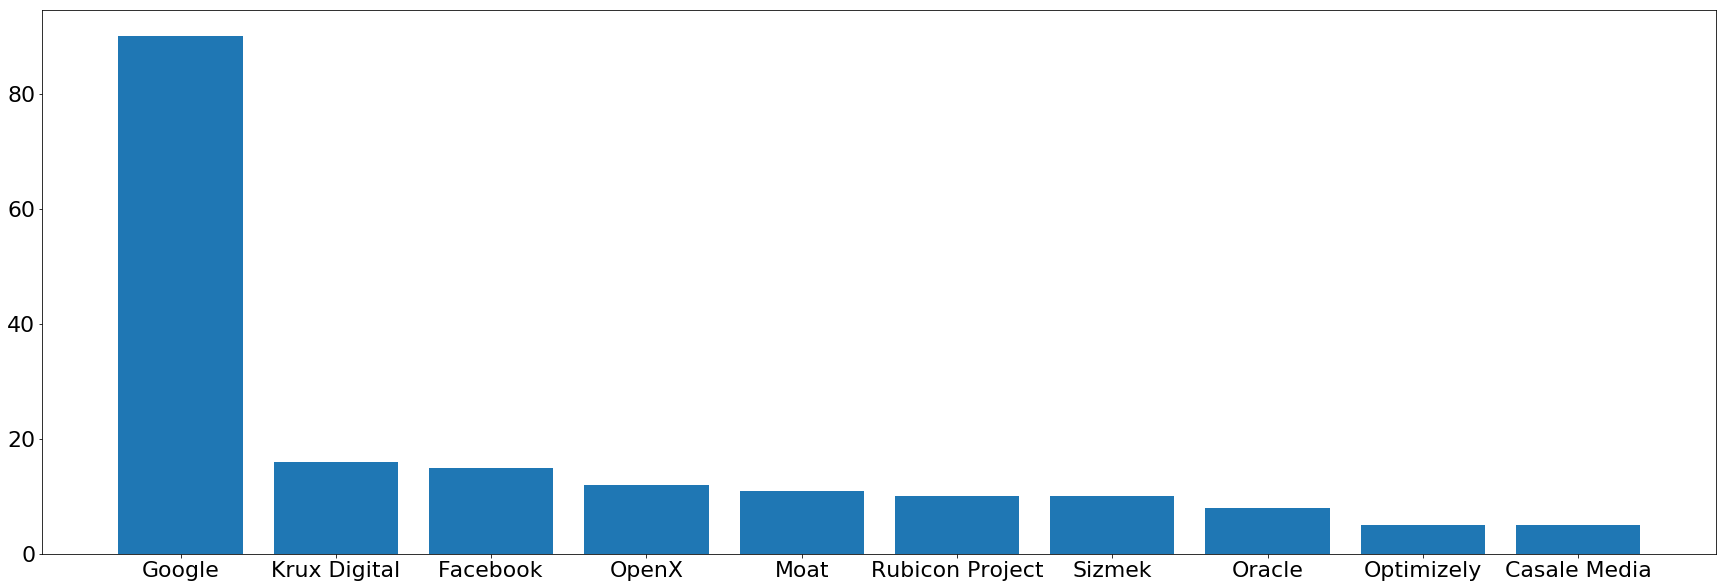

In [2]:
sites = ['http://avclub.com', 'http://nytimes.com', 'http://espn.go.com']

small_crawl.graph_third_party_organizations_found_on_sites(sites)



## Get all third party responses on a site
For a more comprehensive view of the third party resources on a website, run this cell.

`census.get_all_third_party_responses_by_site(top_url)` returns a two-level results dict containing third party urls loaded on the given site's landing page (top_url).

The dict's structure is:

`dict[third_party_url]['is_tracker']`, contains True if third_party_url is identified on a blocklist.  
`dict[third_party_url]['is_js']`, contains True if third_party_url is a script.  
`dict[third_party_url]['is_img']`, contains True if third_party_url is an image.  
`dict[third_party_url]['url_domain']`, contains the domain of the third party.  
`dict[third_party_url]['organization_name']`, contains the name of the third party organization (or `None` if it couldn't be identified).


In [ ]:
results = small_crawl.get_all_third_party_responses_by_site('http://nytimes.com')


print('Example of one of the third parties:')
third_party = results.popitem()

print('Third party URI loaded on page: ' + third_party[0])
print('Third party domain: ' + third_party[1]['url_domain'])
print('Is it a tracker?: ' + str(third_party[1]['is_tracker']))
print('Is it an image?: ' + str(third_party[1]['is_img']))
print('Is it a script?: ' + str(third_party[1]['is_js']))
print('Name of third party organizations: ' + str(third_party[1]['organization_name']))

## Get all third party responses for a list of sites
Run the cell below to fetch third party data for multiple sites. The results are written to CSV files in the `results/` directory — visit the Jupyter Notebook file browser at https://webcensus.openwpm.com/ to view and download the files.

The resulting CSVs are:

* `tracker_js_by_site.csv` : A CSV of rows of [site, tp_domain] for third-party domains with tracking scripts on that site.

* `non_tracker_js_by_site.csv` : A CSV of rows of [site, tp_domain] for third-party domains with non-tracking scripts on that site

* `tracker_img_by_site.csv` : A CSV of rows of [site, tp_domain] for third-party domains with tracking images (pixels, beacons, ads, etc.) on that site.

* `non_tracker_img_by_site.csv` : A CSV of rows of [site, tp_domain] for third-party domains with non-tracking images on that site

* `tracker_other_by_site.csv` : A CSV of rows of [site, tp_domain] for domains of third-party resources that could not be identified as scripts or images, but were still identified as trackers

* `non_tracker_other_by_site.csv` : A CSV of rows of [site, tp_domain] for domains of third-party resources that could not be identified as scripts, images, or trackers.

In [2]:
# List sites to fetch data for :
sites = ['http://cnn.com', 'http://wsj.com']

# This function will write the results to multiple CSVs
small_crawl.get_third_party_resources_for_multiple_sites(sites, filepath='results/')

print("Check file browser at https://webcensus.openwpm.com/results to see output.")

Following sites not found in dataset: ['http://defnotindataset.com']
NOTE: all sites in census are indexed by http://[domain_name].[tld]
Query results written to filesystem.
Check file browser at https://webcensus.openwpm.com/results to see output.


## Get sites that load a resource from a given third party domain

`census.get_top_urls_with_third_party_domain(tp_domain)` returns a dictionary mapping sites in the census to a list of resources loaded on that site belonging to that tp_domain.

In [ ]:
tp_domain = 'addthis.com'

tps_by_top = small_crawl.get_sites_with_third_party_domain(tp_domain)

print("Number of sites with given third party : " + str(len(tps_by_top)))

## Get "cookie sync" events on a given site
"Cookie syncing" is a practice that allows one third party to share the value of a user's cookie with a different third party. The practice is described in [this Freedom-to-Tinker blogpost](https://freedom-to-tinker.com/2014/08/07/the-hidden-perils-of-cookie-syncing/). Sharing identifiers with other third parties allows third parties to expand the tracking services they can provide to customers.


Use `get_cookie_syncs_by_site(site, cookie_length)` to get a dictionary mapping third-party domains to tuples of (domain, cookie_value) that share a cookie with that third-party.

Note: This does not include logic for isolating "identifying cookies." Any cookies of a sufficient cookie length that are shared with other domains will be identified.

In [ ]:
# The in order for a cookie to be considered cookie syncing,
# it must be at least cookie_length characters long
results = small_crawl.get_cookie_syncs_by_site('http://microsoft.com', cookie_length=8)

for receiving_url in results:
    print("Domain receiving cookie: " + receiving_url)
    for sending_url, val in results[receiving_url]:
        print("\tDomain sharing cookie: " + sending_url)
        print("\tCookie value: " + val)

## Get "cookie sync" events on multiple sites
Run this cell to get data on cookie syncing from multiple sites. The results are written to CSV files in the `results/` directory — visit the Jupyter Notebook file browser at https://webcensus.openwpm.com/ to view and download the files.

The resulting CSV files are:

* `condensed_cookie_syncs.csv` : A CSV containing domains of third-parties receiving cookies and the domains sharing cookies, by site.
* `full_cookie_syncs.csv` : A CSV with rows containing the URL used to sync a cookie, the domain sharing the cookie, the cookie value, and the site the cookie sync took place on.


*Note*: This function can be a bit slow for a longer list of sites, so please be patient.

In [ ]:
sites = ['http://microsoft.com', 'http://cnn.com']

small_crawl.get_cookie_syncs_for_multiple_sites(sites, filepath='results/')

print("Check file browser at https://webcensus.openwpm.com/results to see output.")

## Check a given url against a blocklist
Run the cell below to check a url against one of two blocklists.

Available blocklists (described above):
* `easylist`
* `easyprivacy`

In [ ]:
url_to_check = 'http://tags.bkrtx.com/js/bk-coretag.js'

# Set is_js if url is known to be a script resource (or unset if unknown).
# Set is_img if url is known to be an image (or unset if unknown).
# If first_party site on which URL appeared is known, provide it as first_party.
# Else, leave unset.
utils.is_tracker(url_to_check, is_js=True, is_img=False, 
                 first_party='http://verizonwireless.com', blocklist='easyprivacy')


## Get the domain of a given url
The cell below strips a URL down to just it's domain ([public suffix](https://publicsuffix.org/) + hostname)

In [ ]:
utils.get_domain('http://subdomain.example.com/this/will/be/deleted.jpg')